In [1]:
import kwant
import matplotlib.pyplot as plt
import numpy as np
from ccode.modified_boundstate import modified_find_boundstates
from ccode.boundstate import find_boundstates, extract_boundstates
import scipy.sparse.linalg as sla
import time

%matplotlib inline
plt.rcParams.update({"font.size": 12})

# Minimal example of bound state algorithm

All comments are refering to wires of width 3, but discussion holds for thicker wires.

Modifications of the original algorithm:
* Interval of energies is sorted such that is starts looking around zero energy.
* Search of energy candidates stops after having two candidates.

Other modifications are just printing times

#### Helper functions

In [2]:
def sort_eigen(ev):
    """
    Sort eigenvectors and eigenvalues using numpy methods.
    """
    evals, evecs = ev
    idx = np.argsort(evals)
    evals = evals[idx]
    evecs = evecs[:, idx]
    return evals, evecs.T

In [3]:
cavity_hamiltonian = """
    ( t * (k_x**2 + k_y**2 ) - mu_cavity) * kron(sigma_0, sigma_z)
    + alpha * k_x * kron(sigma_y, sigma_z)
    - alpha * k_y * kron(sigma_x, sigma_z)
    + B_x * kron(sigma_x, sigma_0)
"""

cavity_template = kwant.continuum.discretize(cavity_hamiltonian)

/tmp/ipykernel_2690/1296386344.py:8: KwantDeprecationWarning: Accessing kwant.continuum without an explicit import is deprecated. Instead, explicitly 'import kwant.continuum'.
  cavity_template = kwant.continuum.discretize(cavity_hamiltonian)
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(


In [4]:
lead_hamiltonian = """
    ( t * (k_x**2 + k_y**2 ) - mu) * kron(sigma_0, sigma_z)
    + alpha * k_x * kron(sigma_y, sigma_z)
    - alpha * k_y * kron(sigma_x, sigma_z)
    + Delta * kron(sigma_0, sigma_x)
    + B_x * kron(sigma_x, sigma_0)
"""

a = 1
lead_template = kwant.continuum.discretize(lead_hamiltonian, grid=a)

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(


In [5]:
# Hamiltonian of the system
finite_hamiltonian = """
    ( t * (k_x**2 + k_y**2 ) - mu(x,y)) * kron(sigma_0, sigma_z)
    + alpha * k_x * kron(sigma_y, sigma_z)
    - alpha * k_y * kron(sigma_x, sigma_z)
    + Delta(x,y) * kron(sigma_0, sigma_x)
    + B_x * kron(sigma_x, sigma_0)
"""
finite_template = kwant.continuum.discretize(finite_hamiltonian, grid=a)

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(


In [6]:
def circle_shape(r):
    def shape(site):
        x, y = site.pos
        return x**2 + y**2 < r**2
    return shape


def make_circular_cavity(r):
    junction = kwant.Builder()
    junction.fill(
        cavity_template,
        shape=circle_shape(r),
        start=[0,0]
    )
    return junction

In [7]:
def circle_junction_shape(r, l, w):
    def shape(site):
        x, y = site.pos
        return x**2 + y**2 < r**2 or (np.abs(x) < l + r and np.abs(y) < w/2)
    return shape


def make_circular_junction(r, l, w):
    junction = kwant.Builder()
    junction.fill(
        finite_template,
        shape=circle_junction_shape(r, l, w),
        start=[0, 0]
    )
    return junction.finalized()


def shape_wires_circle(r, mu_circle, mu_wires):
    def shape(x, y):
        if x**2 + y**2 < r**2:
            return mu_circle
        else:
            return mu_wires
    return shape


def f_params_circular_junction(r, **parameters):
    #print(parameters)
    params = parameters.copy()
    mu_circle = params.pop('mu_cavity')
    mu_wires = params.pop('mu_wires')
    Delta = params['Delta']

    params.update(mu=shape_wires_circle(r=r,
                                        mu_circle=mu_circle,
                                        mu_wires=mu_wires))
    params.update(Delta=shape_wires_circle(r=r,
                                        mu_circle=0,
                                        mu_wires=Delta))


    return params

## Circular junction

### Bound state algorithm

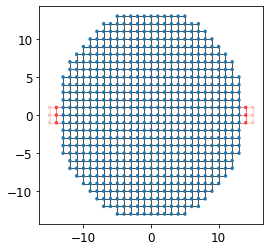

In [42]:
# create system
circle = make_circular_cavity(r=14)
lead = kwant.Builder(symmetry=kwant.TranslationalSymmetry([-1, 0]))
W = 3
# lead position
x0 = -9
y0 = 0
lead.fill(lead_template,
          shape=lambda site: -W/2 + y0 <= site.pos[1] < W/2 + y0,
          start=[x0, y0]);
circle.attach_lead(lead)
circle.attach_lead(lead.reversed())
circle = circle.finalized()
fig, ax = plt.subplots(figsize=(4, 4))
kwant.plot(circle, ax=ax);

In [58]:
# parameters such that MBS will be coupled
# the topological gap at B = 0.5 is gap* = 0.05
# therefore min_energy = -gap* and max_energy = gap*
params = {
    't': 1,
    'mu': 0.3,
    'mu_cavity': 0.4,
    'alpha': 0.3,
    'Delta': 0.3,
    'B_x': 0.5
}

In [59]:
%%time
# execution of modified bs algorithm
# extracted energy and computation time depend strongly on rtol
# rtol = 1e-2; time = 2.05 s; energy = 0.026
# rtol = 1e-3; time = 4.27 s; energy = 0.008
# rtol = 1e-4; time = 26.4 s; energy = 0.006
en, vec = modified_find_boundstates(syst=circle,
                           min_energy=-0.05,
                           max_energy=0.05,
                           sparse=True,
                           params=params,
                           rtol= 1e-3
                          )

Time evaluate bound state condition: 0.2883315086364746
Time evaluate bound state condition: 0.25163888931274414
Time find bound state energy: 0.40967869758605957
Time evaluate bound state condition: 0.19053387641906738
Time evaluate bound state condition: 0.21339654922485352
Time evaluate bound state condition: 0.16267156600952148
Time evaluate bound state condition: 0.23804521560668945
Time evaluate bound state condition: 0.20522832870483398
Time evaluate bound state condition: 0.20496916770935059
Time evaluate bound state condition: 0.20327401161193848
Time evaluate bound state condition: 0.17440247535705566
Time evaluate bound state condition: 0.17416095733642578
Time evaluate bound state condition: 0.17580747604370117
Time evaluate bound state condition: 0.18101906776428223
Time evaluate bound state condition: 0.18283534049987793
Time evaluate bound state condition: 0.17820167541503906
Time evaluate bound state condition: 0.17772603034973145
Time find bound state energy: 0.4326791

In [60]:
en

array([0.00856191])

In [61]:
# check that no bound state is found at energy zero
extract_boundstates(syst=circle, params=params)

array([], shape=(2460, 0), dtype=complex128)

In [63]:
# it is found at the energy given by find_boundstates
extract_boundstates(syst=circle, params=params, energy=0.00856191)

array([[-0.00305256+0.00311168j],
       [ 0.00217365-0.00296957j],
       [ 0.00522029-0.00764035j],
       ...,
       [-0.02490453+0.00096242j],
       [-0.00627313-0.01238048j],
       [-0.00348168-0.00495899j]])

In [64]:
# it gives an eigenvector even for all energies even if not found by find_boundstates
# in this case the energy is taken from sparse diag
lowest_en = 6.57352400e-03
extract_boundstates(syst=circle, params=params, energy=lowest_en)

array([[-0.000426  +0.00097786j],
       [ 0.01871139+0.03131855j],
       [ 0.00015493-0.00142841j],
       ...,
       [-0.02547358+0.02446849j],
       [-0.01937182-0.00162499j],
       [ 0.00183483+0.0036759j ]])

In [46]:
%%time
# execution of original bs algorithm
# lowest extracted bound state is the same as the previous case
# but computation takes much longer due to consideration of all candidates
# rtol = 1e-2; time = 14 s
# energies = 0.02658972,  0.04001602
# rtol = 1e-3; time = 51.3 s
# energies = 0.00856191,  0.01915394,  0.02551161,  0.04001602,  0.04723886
# rtol = 1e-4; time = 3 min 38 s
# energies = 0.00657352,  0.00856191,  0.01915394, 0.02551161,  0.02658972,  0.04001602,  0.04723886
en, vec = find_boundstates(syst=circle,
                           min_energy=-0.05,
                           max_energy=0.05,
                           sparse=True,
                           params=params,
                           rtol=1e-3
                          )

Time evaluate bound state condition: 0.24169921875
Time evaluate bound state condition: 0.20255374908447266
Time evaluate bound state condition: 0.20300078392028809
Time find bound state energy: 0.4346141815185547
Time evaluate bound state condition: 0.16791653633117676
Time evaluate bound state condition: 0.1676621437072754
Time evaluate bound state condition: 0.16587543487548828
Time evaluate bound state condition: 0.16337084770202637
Time find bound state energy: 2.952437400817871
Time evaluate bound state condition: 0.16475939750671387
Time evaluate bound state condition: 0.16491389274597168
Time evaluate bound state condition: 0.1618950366973877
Time find bound state energy: 0.4988546371459961
Time evaluate bound state condition: 0.16930413246154785
Time evaluate bound state condition: 0.17521977424621582
Time evaluate bound state condition: 0.1713240146636963
Time evaluate bound state condition: 0.17133307456970215
Time evaluate bound state condition: 0.19138360023498535
Time eva

In [47]:
en

array([-0.04723886, -0.04001602, -0.02551161, -0.01915394, -0.00856191,
        0.00856191,  0.01915394,  0.02551161,  0.04001602,  0.04723886])

In [52]:
# note that the lowest state is not the true lowest state found from sparse diagonalisation

### Sparse diagonalization

(-16.0, 16.0)

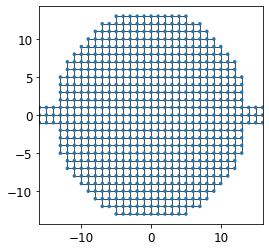

In [48]:
circle_junction = make_circular_junction(r=14, l=200, w=3)
fig, ax = plt.subplots(figsize=(4, 4))
kwant.plot(circle_junction, ax=ax);
ax.set_xlim(-16, 16)

In [49]:
params = {
    't': 1,
    'mu_wires': 0.3,
    'mu_cavity': 0.4,
    'alpha': 0.3,
    'Delta': 0.3,
    'B_x': 0.5
}

In [50]:
%%time
# sparse diagonalization finds all bound states in 601 ms
# energies = 6.57e-03, 8.56e-03,  1.91e-02,  2.55e-02,  2.65e-02, 4.00e-02,  4.72e-02
# lowest state found in 200 ms
ham = circle_junction.hamiltonian_submatrix(sparse=True,
                                            params=f_params_circular_junction(r=14, **params))
val, vec = sort_eigen(sla.eigsh(ham.tocsc(), k=4, sigma=0))

CPU times: user 207 ms, sys: 6.97 ms, total: 214 ms
Wall time: 210 ms


In [51]:
val

array([-6.57352402e-03, -2.66442154e-17, -1.94535875e-17,  6.57352400e-03])

In [35]:
# we conclude that sparse diagonalization is faster than the current bs algorithm
# times shown are for wires of width = 3, but general behaviour holds for thicker systems
# for example, for wires width = 9:
# sparse time = 1.19 s vs modified bs time = 6.9 s vs full bs = 8.41 with rtol = 1e-2
# for wires width = 13
# sparse time = 920 ms vs modified bs time = 6.82 s vs full bs time = 1 min 18 s with rtol = 1e-3
# rtol chosen s.t. lowest state is found
# if not small enough, bs algorithm finds second bound state

In [36]:
# sanity check, look for majoranas by depleting the cavity

In [37]:
params = {
    't': 1,
    'mu_wires': 0.3,
    'mu_cavity': -2,
    'alpha': 0.3,
    'Delta': 0.3,
    'B_x': 0.5
}

In [38]:
%%time
# sparse diagonalization finds all bound states in 601 ms
# energies = 6.57e-03, 8.56e-03,  1.91e-02,  2.55e-02,  2.65e-02, 4.00e-02,  4.72e-02
# lowest state found in 200 ms
ham = circle_junction.hamiltonian_submatrix(sparse=True,
                                            params=f_params_circular_junction(r=14, **params))
val, vec = sort_eigen(sla.eigsh(ham.tocsc(), k=4, sigma=0))

CPU times: user 162 ms, sys: 7.03 ms, total: 169 ms
Wall time: 166 ms


In [39]:
val

array([-1.97015585e-12, -1.97004890e-12,  1.96996991e-12,  1.97007686e-12])

In [40]:
density = kwant.operator.Density(circle_junction, np.eye(4))

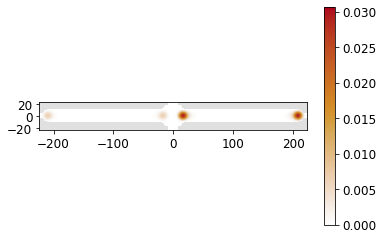

/tmp/ipykernel_2690/4131955867.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  kwant.plotter.density(circle_junction, density(vec[2]));


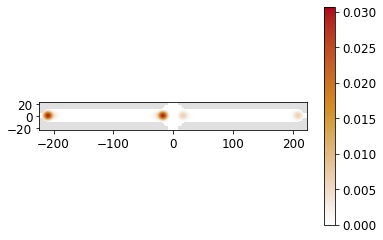

/tmp/ipykernel_2690/4131955867.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  kwant.plotter.density(circle_junction, density(vec[1]));


In [41]:
kwant.plotter.density(circle_junction, density(vec[2]));
kwant.plotter.density(circle_junction, density(vec[1]));